# NLP model to predict from title (ULMFiT)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.text import *

In [ ]:
pretrained_path = Path('~/datasets/wikimedia').expanduser()

## Load data

In [4]:
df = pd.read_feather('tabular-df')

In [5]:
columns = ['title', 'target']
df = df[columns]
N = -10000
train_df = df[:N]
valid_df = df[N:]

## Languaje model

In [35]:
data_lm = TextLMDataBunch.from_df('.', train_df, valid_df, tokenizer=Tokenizer(lang='es'), text_cols='title')

In [40]:
# pretrained model (spanish wiki)
pretraind_fnames = (pretrained_path/'models/weights-6', pretrained_path/'itos')
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_fnames=pretraind_fnames)

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


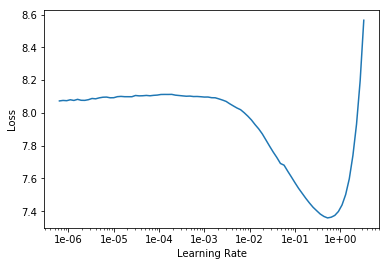

In [10]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8, 0.7))

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      5.177172    4.802299    0.309109  (00:23)



In [12]:
learn.save('fit-head')

In [28]:
learn.load('fit-head');

In [29]:
learn.unfreeze()
learn.fit_one_cycle(6, 3e-3, moms=(0.8, 0.7))

Total time: 02:52
epoch  train_loss  valid_loss  accuracy
1      4.552735    4.594989    0.326132  (00:27)
2      4.448153    5.098676    0.257221  (00:28)
3      4.126873    4.391115    0.337241  (00:29)
4      3.803120    4.354942    0.343525  (00:29)
5      3.485168    4.389339    0.344239  (00:29)
6      3.294815    4.425426    0.342907  (00:29)



In [30]:
learn.save('fine-tuned')

In [8]:
learn.load('fine-tuned');

In [35]:
learn.predict('samsung', 5, temperature=1.1, min_p=0.001)

Total time: 00:00



'samsung galaxy tab , lo mejor'

In [36]:
learn.save_encoder('fine-tuned-enc')

In [37]:
pickle.dump(data_lm.vocab, open('itos', 'wb'))

## Title classifier

In [6]:
vocab = pickle.load(open('itos', 'rb'))

In [7]:
data_clf = TextClasDataBunch.from_df('.', train_df, valid_df, df, tokenizer=Tokenizer(lang='es'), 
                                     vocab=vocab, text_cols='title', label_cols='condition')

In [19]:
learn = text_classifier_learner(data_clf, max_len=100, drop_mult=0.5)

In [20]:
learn.load_encoder('fine-tuned-enc')
learn.freeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


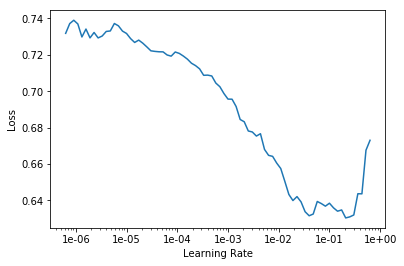

In [14]:
learn.recorder.plot(skip_end=8)

In [21]:
learn.fit_one_cycle(1, 3e-3, moms=(0.8, 0.7))

Total time: 00:25
epoch  train_loss  valid_loss  accuracy
1      0.502706    0.497329    0.769300  (00:25)



In [22]:
learn.save('first')

In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

Total time: 00:29
epoch  train_loss  valid_loss  accuracy
1      0.478203    0.451679    0.795000  (00:29)



In [24]:
learn.save('second')

In [25]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

Total time: 00:42
epoch  train_loss  valid_loss  accuracy
1      0.472015    0.437852    0.802800  (00:42)



In [26]:
learn.save('third')

In [27]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4/(2.6**4), 1e-4), moms=(0.8, 0.7))

Total time: 10:32
epoch  train_loss  valid_loss  accuracy
1      0.447866    0.431794    0.805600  (01:02)
2      0.434827    0.429153    0.805000  (01:02)
3      0.433098    0.418664    0.811900  (01:04)
4      0.440408    0.415776    0.811500  (01:03)
5      0.440411    0.414932    0.812300  (01:02)
6      0.431286    0.417159    0.811300  (01:02)
7      0.421277    0.405521    0.819000  (01:02)
8      0.422464    0.410475    0.816700  (01:05)
9      0.415283    0.423141    0.808500  (01:02)
10     0.433402    0.412326    0.815200  (01:03)



In [28]:
learn.save('final')

## Predict

In [142]:
learn.load('final');

In [29]:
learn.predict('iphone 7 como nuevo') # 'iphone 7 as new'

('used', tensor(1), tensor([0.0055, 0.9945]))

In [30]:
preds, _ = learn.get_preds(DatasetType.Test, ordered=True)

In [32]:
preds_df = pd.DataFrame({'title_isnew_prob': preds[:,0]})
preds_df.head()

,title_isnew_prob
0,0.972612
1,0.840828
2,0.000209
3,0.890611
4,0.145972


In [ ]:
# save predictions
preds_df.to_feather(PATH/'title-df')